## *New* re-run of re-tweet (predictive) analyses using new data from David
*updated: 3/21 (with data sent 3/14)*

In [1]:
# hide warnings to keep things tidy.
import warnings
warnings.filterwarnings('ignore')

import json
from pprint import pprint

import pandas as pd
import numpy as np 
import scipy as sp
import nltk
import sklearn
import statsmodels 
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 

import snowball


In [2]:
with open("original_tweets_unique.json") as updated_tweets_f:
    # the transpose is to re-shape so that rows are
    # tweets (cols are attributes)
    tweet_df = pd.read_json(updated_tweets_f)

In [3]:
tweet_df.shape

(12975, 29)

In [4]:
tweet_df.head()

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,scopes,source,text,truncated,user
0,NaN,None,2009-09-29 19:26:02,"{'hashtags': [{'indices': [0, 5], 'text': 'new...",NaN,2,False,None,4477687173,4477687173,...,NaN,NaN,NaN,8,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#news: British girl dies after cervical cancer...,False,"{'utc_offset': -25200, 'description': 'Conserv..."
1,NaN,None,2009-11-25 23:07:01,"{'hashtags': [{'indices': [73, 85], 'text': 'o...",NaN,0,False,None,6064161577,6064161577,...,NaN,NaN,NaN,4,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","RT @SamValley We Wish You a Lucky Mammogram, a...",False,"{'utc_offset': -21600, 'description': 'Politic..."
2,NaN,None,2011-02-04 21:49:10,"{'hashtags': [], 'user_mentions': [], 'symbols...",NaN,1,False,None,33643250145296385,33643250145296384,...,NaN,NaN,NaN,4,False,NaN,"<a href=""http://www.exacttarget.com/social"" re...",This week’s podcast: a new antibiotic for C. d...,False,"{'utc_offset': -18000, 'description': 'Johns H..."
3,NaN,None,2011-03-17 04:15:40,"{'hashtags': [], 'user_mentions': [], 'symbols...",NaN,0,False,None,48236030637244417,48236030637244416,...,NaN,NaN,NaN,2,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",i eat more pussy that cervical cancer.,False,"{'utc_offset': -18000, 'description': '', 'url..."
4,NaN,None,2011-08-07 02:01:02,"{'hashtags': [{'indices': [133, 140], 'text': ...",NaN,0,False,None,100023613498982401,100023613498982400,...,NaN,NaN,NaN,4,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NVIC to FDA: not reassured by safety data; Mer...,False,"{'utc_offset': -18000, 'description': 'Provide..."


In [5]:
tweet_df.columns

Index(['contributors', 'coordinates', 'created_at', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'geo', 'id',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'retweet_count', 'retweeted', 'scopes',
       'source', 'text', 'truncated', 'user'],
      dtype='object')

### Note that the "retweeted" flag is *uniformly* False in this dataset.

In [6]:
primary_tweets = tweet_df[tweet_df["retweeted"] == False]
retweets = tweet_df[tweet_df["retweeted"] == True]
print("# primary tweets: %s; # retweets: %s" % (
        len(primary_tweets), len(retweets)))

# primary tweets: 12975; # retweets: 0


### Here I try and predict the number of retweets as a function of the number of followers one has. 

Assumptions and caveats: 
* The number of followers of the user who issued the *original* tweet is in the field
'user':''followers_count'. 
* Note that this seems cleaner than it was with the last version of the dataset, wherein this field was often missing. Thanks to David for clearning this up!

In [7]:
primary_tweets["user"].values[0]["followers_count"]

9112

In [8]:
len(primary_tweets["user"])

12975

Looks like we've got ~00 of these.

In [9]:
X,y = [], []
for index, tweet in primary_tweets.iterrows():
    X.append(tweet["user"]["followers_count"])
    y.append(tweet["retweet_count"])

I print out stats below; note that (apparently) the mean number of followers here is 114157. Still seems (suspiciously) large to me, but then what I do know. The range is (0, 2.4 mil).

In [10]:
print(sp.stats.describe(X))

DescribeResult(nobs=12975, minmax=(0, 24351276), mean=114157.99606936416, variance=713687072412.37488, skewness=14.895372524798328, kurtosis=311.49847003345)


Now column normalize 

In [11]:
# build
X = np.matrix(X).T
X_user_normed = X/X.max()
#X_user_normed = sm.add_constant(X_user_normed, prepend=True)
print(sp.stats.describe(X_user_normed))

DescribeResult(nobs=12975, minmax=(array([ 0.]), array([ 1.])), mean=array([ 0.00468797]), variance=array([ 0.00120355]), skewness=array([ 14.89537252]), kurtosis=array([ 311.49847003]))


Re-tweet counts, meanwhile, seem sane.

In [12]:
print(sp.stats.describe(y))

DescribeResult(nobs=12975, minmax=(0, 1588), mean=7.6710597302504819, variance=2229.7609128201561, skewness=18.590066101591294, kurtosis=467.02416240790234)


In [13]:
# prepare data for statsmodels
X = X_user_normed
y = np.array(y)
print("X shape: %s; y shape: %s" % (X.shape, y.shape))

X shape: (12975, 1); y shape: (12975,)


Now fit the model; again this is just using the raw number of followers as the independent var and the retweet count as the dependent.

In [14]:
user_model = sm.OLS(y, sm.add_constant(X, prepend=True))
user_only_results = user_model.fit()
print(user_only_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1121.
Date:                Tue, 22 Mar 2016   Prob (F-statistic):          7.73e-236
Time:                        19:29:33   Log-Likelihood:                -67889.
No. Observations:               12975   AIC:                         1.358e+05
Df Residuals:                   12973   BIC:                         1.358e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.8714      0.401     14.629      0.0

This looks even more sane than the previous analysis; the number of followers has a reasonably strong positive correlation with the number of retweets, as we would expect! Although not exactly a *great* fit, as can be seen below (this is hardly a huge surprise though)

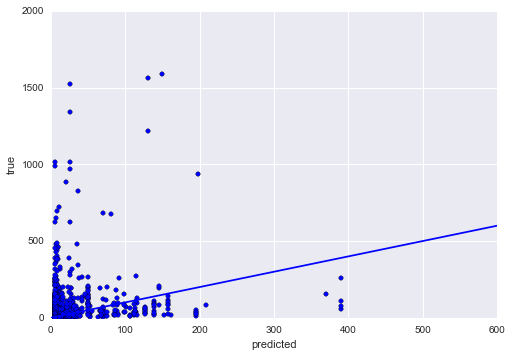

In [15]:
yhat = user_only_results.fittedvalues
fig, ax = plt.subplots()
ax.scatter(yhat, y)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_ylim((0,2000))
ax.set_xlim((0,600)) # excluding some outliers here
line_fit = sm.OLS(y,sm.add_constant(yhat, prepend=True)).fit()
fitted_plot = abline_plot(model_results=line_fit, ax=ax)

Now introduce text features (simple unigrams for now) as well. Here I severely limit predictor set (to 200 most frequent words); can of course try to extend this!

In [16]:
## 
# build text features. 
stop_words = list(sklearn.feature_extraction.stop_words.ENGLISH_STOP_WORDS)
stop_words.extend([str(x) for x in range(2001)]) # remove numbers, too
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=True, 
                                        stop_words=stop_words, ngram_range=(1, 2),
                                        max_features=200, min_df=20)
X_text = vectorizer.fit_transform(primary_tweets["text"])
X_text.shape

(12975, 200)

In [17]:
X_user_normed = sm.add_constant(X_user_normed, prepend=True)
X_all  = X_text.copy().todense()
X_all  = np.hstack((X_user_normed, X_all))

In [18]:
indices_to_tokens = dict(zip(list(vectorizer.vocabulary_.values()), list(vectorizer.vocabulary_)))

In [19]:
X_all_df = pd.DataFrame(X_all)
words = [indices_to_tokens[idx] for idx in range(X_text.shape[1])]
col_names = ["intercept", "followers"]
col_names.extend(words)
X_all_df.columns = col_names

In [20]:
model_all = sm.OLS(y, X_all_df)
results_all = model_all.fit()
print(results_all.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     7.183
Date:                Tue, 22 Mar 2016   Prob (F-statistic):          1.56e-174
Time:                        19:29:39   Log-Likelihood:                -67732.
No. Observations:               12975   AIC:                         1.359e+05
Df Residuals:                   12773   BIC:                         1.374e+05
Df Model:                         201                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
intercept                3.5086 

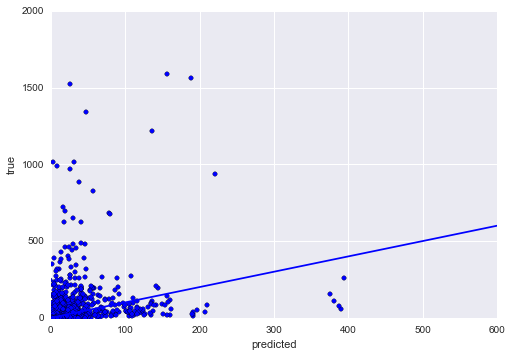

In [21]:
yhat = results_all.fittedvalues
fig, ax = plt.subplots()
ax.scatter(yhat, y)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_ylim((0,2000))
ax.set_xlim((0,600)) # excluding some outliers here
line_fit = sm.OLS(y,sm.add_constant(yhat, prepend=True)).fit()
fitted_plot = abline_plot(model_results=line_fit, ax=ax)

A note of caution, of course: this is certainly overfit! We have hundreds of predictors and only 13k data points, so results to be taken with a large grain of salt.